# Election analysis

## 0. Importing all the required modules

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## 1. Getting the data

### Creating a parser for the website

In [2]:
list_of_TIKS = []
for i in range (1, 31):
    list_of_TIKS.append('Территориальная избирательная комиссия №' + str(i))

num_of_voters = []
num_of_voters_voted = []
appearence = []
votes_for_Amosov_percent = []
votes_for_Beglov_percent = []
votes_for_Tikhonova_percent = []

url = "http://www.st-petersburg.vybory.izbirkom.ru/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222"
response = requests.get(url)
page = BeautifulSoup(response.content, "lxml")

main_links = page.find_all('a')
for TIK in list_of_TIKS:
    for main_tag in main_links:
        main_link = main_tag.get('href')
        if TIK in main_tag:
            current_TIK = pd.read_html(main_link, encoding='cp1251',  header=0)[7]
            
            num_of_voters.extend(int(current_TIK.iloc[0,i]) for i in range (len(current_TIK.columns)))
            num_of_voters_voted.extend(int(current_TIK.iloc[2,i]) + int(current_TIK.iloc[3,i]) for i in range (len(current_TIK.columns)))
            appearence.extend(round((int(current_TIK.iloc[2,i]) + int(current_TIK.iloc[3,i]))/int(current_TIK.iloc[0,i])*100, 2) for i in range (len(current_TIK.columns)))
            
            votes_for_Amosov_percent.extend(round(float(current_TIK.iloc[12,i][-6]+current_TIK.iloc[12,i][-5]+current_TIK.iloc[12,i][-4]+current_TIK.iloc[12,i][-3]+current_TIK.iloc[12,i][-2]),2) for i in range (len(current_TIK.columns)))
            votes_for_Beglov_percent.extend(round(float(current_TIK.iloc[13,i][-6]+current_TIK.iloc[13,i][-5]+current_TIK.iloc[13,i][-4]+current_TIK.iloc[13,i][-3]+current_TIK.iloc[13,i][-2]),2) for i in range (len(current_TIK.columns)))
            votes_for_Tikhonova_percent.extend(round(float(current_TIK.iloc[14,i][-6]+current_TIK.iloc[14,i][-5]+current_TIK.iloc[14,i][-4]+current_TIK.iloc[14,i][-3]+current_TIK.iloc[14,i][-2]),2) for i in range (len(current_TIK.columns)))


### Data management

In [3]:
interval = 1

interval_num_of_UIKs = []

for i in range (int(100/interval+1/interval)):
    interval_num_of_UIKs.append(0)

for i in range (0, int(100/interval+1/interval), interval):
    for j in range (len(appearence)):
        if appearence[j] < (i + interval/2) and appearence[j] >= (i - interval/2):
            interval_num_of_UIKs[i] = interval_num_of_UIKs[i] + 1

### Plotting data

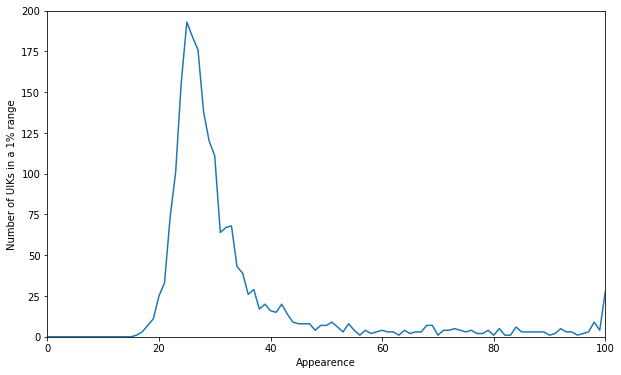

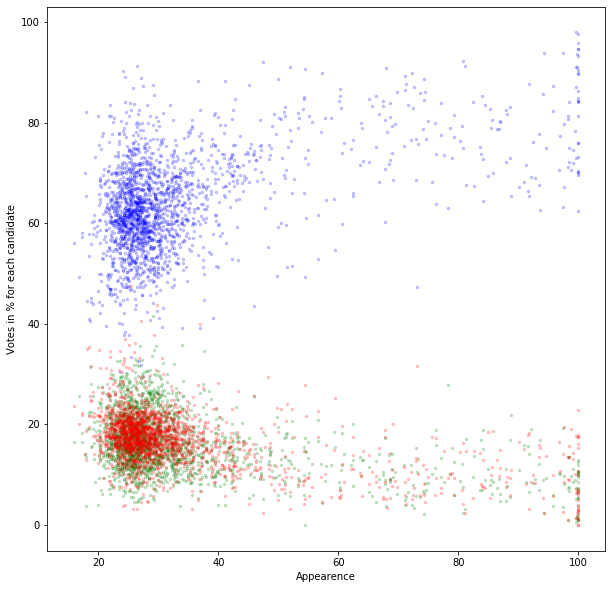

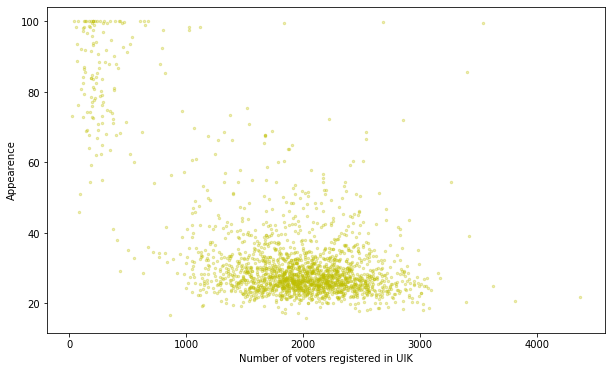

In [4]:
#Number of UIKs (appearence)

plt.figure(figsize=(10, 6))
plt.plot(interval_num_of_UIKs)
plt.axis([0, 100, 0, 200])
plt.ylabel('Number of UIKs in a 1% range')
plt.xlabel('Appearence')
plt.show()

#Votes in percent (appearence)

plt.figure(figsize=(10, 10))
plt.scatter(appearence, votes_for_Amosov_percent, c = 'g', s = 6, alpha=0.2)
plt.scatter(appearence, votes_for_Beglov_percent, c = 'b', s = 6, alpha=0.2)
plt.scatter(appearence, votes_for_Tikhonova_percent, c = 'r', s = 6, alpha=0.2)
plt.ylabel('Votes in % for each candidate')
plt.xlabel('Appearence')
plt.show()

## 2. Vizualization
Because of the data given the dictionary for the further GeoDataframe is written manually

In [5]:
current_UIK = pd.read_html(url, encoding='cp1251',  header=0)[7]

num_of_voters_dist = []
num_of_voters_voted_dist = []
appearence_dist = []

for j in [num_of_voters_dist, num_of_voters_voted_dist, appearence_dist]:
    j.extend(0 for i in range (18))

districts = {
    '0' : [1], #Адмиралтейский
    '1' : [2], #Василеостровский 
    '2' : [18], #Петроградский
    '3' : [16, 30], #Центральный
    '4' : [10, 14, 22], #Выборгский
    '5' : [11, 17], #Калининский
    '6' : [4, 25], #Красногвардейский
    '7' : [5, 24], #Невский
    '8' : [23, 29], #Фрунзенский
    '9' : [9, 12, 28], #Приморский
    '10' : [13], #Курортный
    '11' : [15], #Кронштадтский
    '12' : [21], #Колпинский
    '13' : [20], #Пушкинский
    '14' : [19, 27], #Московский
    '15' : [3, 7], #Кировский
    '16' : [6, 26], #Красносельский
    '17' : [8] #Петродворцовый
}

for i in districts.keys():
    for k in range (1, 31):
        if k in districts[i]:
            num_of_voters_dist[int(i)]= num_of_voters_dist[int(i)] + int(current_UIK.iloc[0,k-1])
            num_of_voters_voted_dist[int(i)] = num_of_voters_voted_dist[int(i)] + int(current_UIK.iloc[2,k-1]) + int(current_UIK.iloc[3,k-1])

for i in range (18):
    appearence_dist[i] = round(num_of_voters_voted_dist[i]/num_of_voters_dist[i]*100, 2)

### Creating GeoDataFrame

In [6]:
SPb_shapes= gpd.read_file('./shapes/Administrative_Discrits.shp', encoding='cp1251')

temp = pd.DataFrame({'Количество избирателей': num_of_voters_dist, 'Явка':appearence_dist })
temp['Район'] = SPb_shapes[['Район']]
temp['geometry'] = SPb_shapes[['geometry']]
SPB_elections_visualization = gpd.GeoDataFrame(temp)

In [7]:
current_UIK = current_UIK.replace(regex=' [0-9]*.[0-9]*%', value='')
percentage = current_UIK.iloc[12:,:-1]
percentage = percentage.rename(index={12:'Amosov', 13:'Beglov', 14:'Tikhonova'})
percentage = percentage.astype(int)
winner = percentage.idxmax(axis=0)
SPB_elections_visualization['Winner'] = list(winner[0:18])
SPB_elections_visualization


,Количество избирателей,Явка,Район,geometry,Winner
0,105510,31.48,Адмиралтейский,"POLYGON ((3373862.288413531 8386676.006542174,...",Beglov
1,147015,31.79,Василеостровский,"POLYGON ((3373864.860662585 8386714.0895593, 3...",Beglov
2,94434,51.53,Петроградский,"POLYGON ((3373924.810420854 8387418.975256226,...",Beglov
3,146350,29.99,Центральный,"POLYGON ((3373933.374672036 8387398.958221314,...",Beglov
4,357721,30.21,Выборгский,"POLYGON ((3378488.128925263 8389146.158719977,...",Beglov
5,358677,27.52,Калининский,"POLYGON ((3378525.240680361 8389152.592761828,...",Beglov
6,261207,29.68,Красногвардейский,"POLYGON ((3384253.297345407 8390009.035046404,...",Beglov
7,381414,26.72,Невский,"POLYGON ((3385142.908936851 8380914.501588236,...",Beglov
8,299683,29.59,Фрунзенский,"POLYGON ((3376633.611700691 8380374.754866237,...",Beglov
9,415345,28.58,Приморский,"POLYGON ((3364708.605618405 8395208.804933313,...",Beglov


### Winner in each district

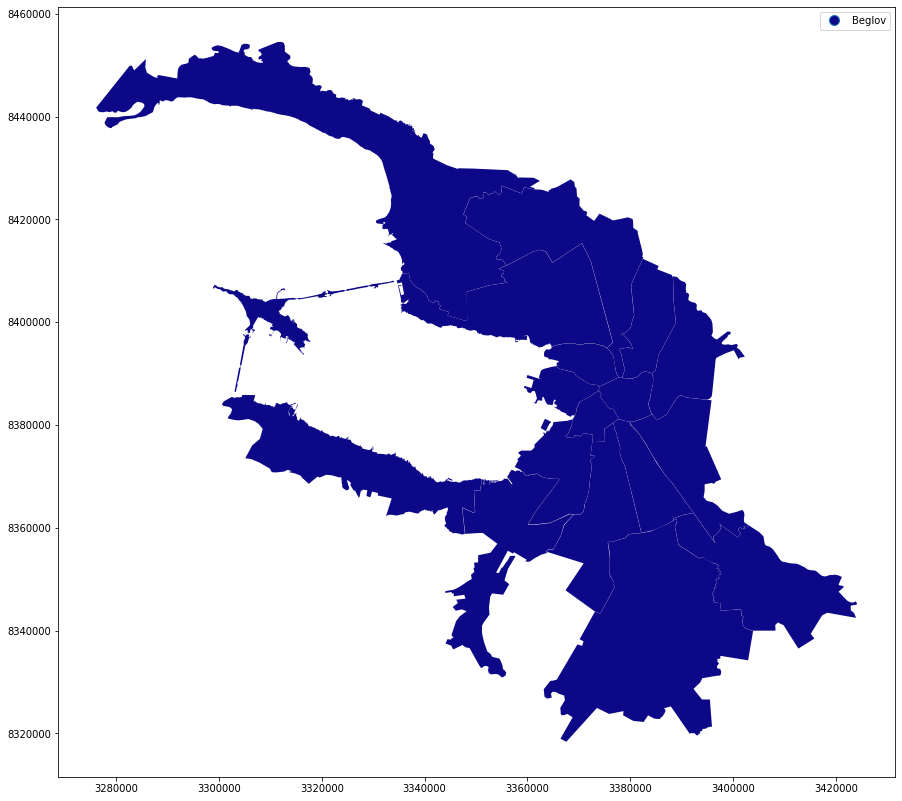

In [135]:
SPB_elections_visualization.plot(column = 'Winner', linewidth=0, cmap='plasma', legend=True, figsize=[15,15])

### Districts

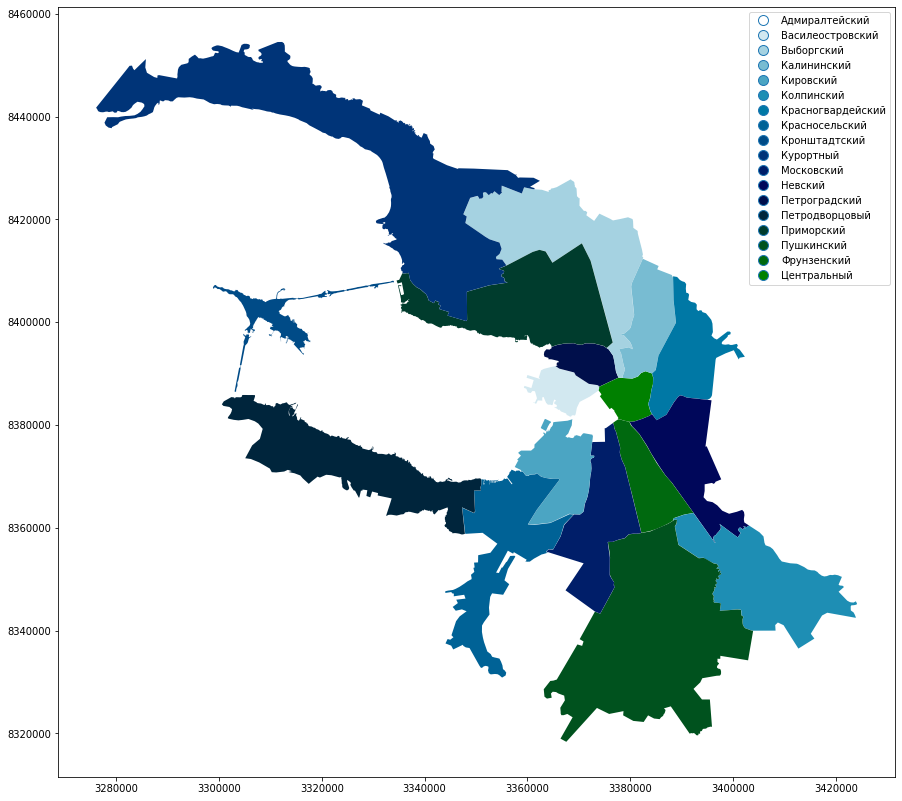

In [8]:
SPB_elections_visualization.plot(column = 'Район', linewidth=0, cmap='ocean_r', legend=True, figsize=[15,15])

### Voters

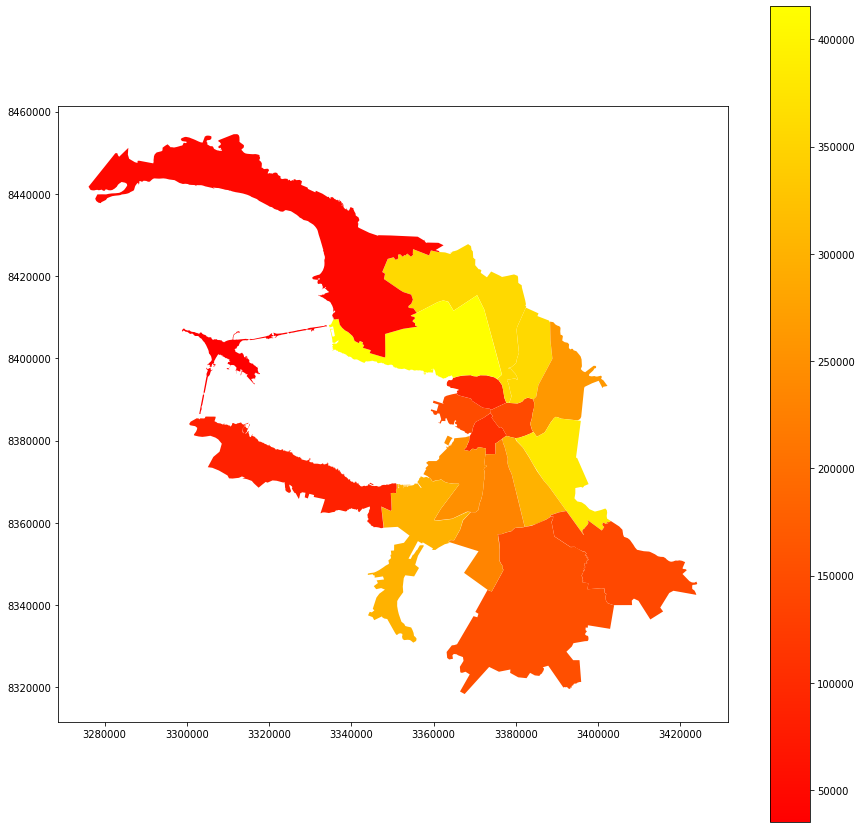

In [14]:
SPB_elections_visualization.plot(column = 'Количество избирателей', linewidth=0, cmap='autumn', legend=True, figsize=[15,15])

### Appearance

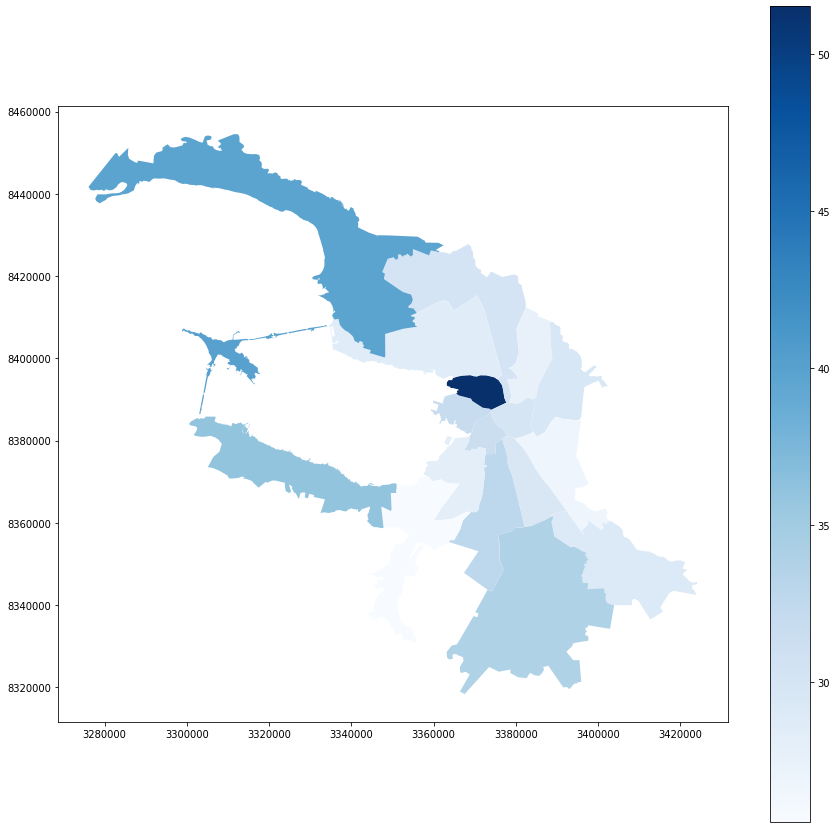

In [13]:
SPB_elections_visualization.plot(column = 'Явка', linewidth=0, cmap='Blues', legend=True, figsize=[15,15])